<a href="https://colab.research.google.com/github/alina-bogdanovskaya/ML_in_Business_Mar2023/blob/lesson5/ML_in_bisiness_HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import itertools
import sys

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('/content/drive/MyDrive/GB/ML in business/Lection5/Churn_Modelling.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#разделим данные на train/test
X = data.drop(['Exited'], axis=1)
y = data.Exited
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
cat_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
cont_columns = ['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
final_transformers = list()

credit_score_transformer = Pipeline([
            ('selector', NumberSelector(key='CreditScore')), 
            ('minmax', MinMaxScaler())
        ])

final_transformers.append(('CreditScore', credit_score_transformer))

for cat_col in cat_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in cont_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [9]:
final_transformers

[('CreditScore',
  Pipeline(steps=[('selector', NumberSelector(key='CreditScore')),
                  ('minmax', MinMaxScaler())])),
 ('Geography',
  Pipeline(steps=[('selector', FeatureSelector(column='Geography')),
                  ('ohe', OHEEncoder(key='Geography'))])),
 ('Gender', Pipeline(steps=[('selector', FeatureSelector(column='Gender')),
                  ('ohe', OHEEncoder(key='Gender'))])),
 ('Tenure', Pipeline(steps=[('selector', FeatureSelector(column='Tenure')),
                  ('ohe', OHEEncoder(key='Tenure'))])),
 ('HasCrCard',
  Pipeline(steps=[('selector', FeatureSelector(column='HasCrCard')),
                  ('ohe', OHEEncoder(key='HasCrCard'))])),
 ('IsActiveMember',
  Pipeline(steps=[('selector', FeatureSelector(column='IsActiveMember')),
                  ('ohe', OHEEncoder(key='IsActiveMember'))])),
 ('Age', Pipeline(steps=[('selector', NumberSelector(key='Age')),
                  ('standard', StandardScaler())])),
 ('Balance', Pipeline(steps=[('selector'

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [ ]:
logreg = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression()),
])

logreg.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('CreditScore',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='CreditScore')),
                                                                 ('minmax',
                                                                  MinMaxScaler())])),
                                                ('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gende...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', LogisticRegression())])

In [ ]:
# наши прогнозы для тестовой выборки
preds_lr = logreg.predict_proba(X_test)[:, 1]
preds_lr[:10]

array([0.02600508, 0.09265914, 0.08653174, 0.03561658, 0.06882608,
       0.17189706, 0.42907026, 0.54987278, 0.1382759 , 0.0568302 ])

In [ ]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, preds_lr)

fscore_lr = (2 * precision_lr * recall_lr) / (precision_lr + recall_lr + sys.float_info.epsilon)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
print(f'Best Threshold={thresholds_lr[ix_lr]}, F-Score={fscore_lr[ix_lr]:.3f}, Precision={precision_lr[ix_lr]:.3f}, Recall={recall_lr[ix_lr]:.3f}')

Best Threshold=0.27512810742374894, F-Score=0.503, Precision=0.477, Recall=0.531


Confusion matrix, without normalization
[[1684  300]
 [ 243  273]]


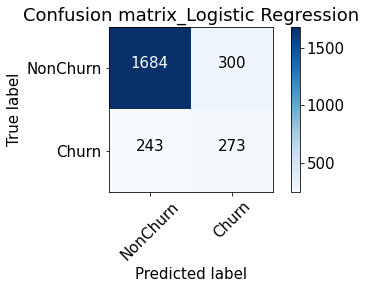

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, preds_lr > thresholds_lr[ix_lr])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix_lr, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix_Logistic Regression')
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
TN_lr = cnf_matrix_lr[0][0]
FP_lr = cnf_matrix_lr[0][1]
FN_lr = cnf_matrix_lr[1][0]
TP_lr = cnf_matrix_lr[1][1]


retain_sum_lr = (FP_lr + TP_lr) * 1
income_lr = TP_lr * 2

income_lr - retain_sum_lr

-27

In [ ]:
%%time

params_lr = {
    'classifier__C':  [100, 10, 1.0, 0.1, 0.01],
    'classifier__solver':  ['newton-cg', 'lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(logreg,
                    param_grid=params_lr,
                    cv=6,
                    refit=False)

search_lr = grid_lr.fit(X_train, y_train)
search_lr.best_params_

CPU times: user 8.33 s, sys: 6.23 s, total: 14.6 s
Wall time: 9.05 s


{'classifier__C': 0.1, 'classifier__solver': 'newton-cg'}

In [ ]:
logreg = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(C=0.1, solver='newton-cg')),
])

logreg.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('CreditScore',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='CreditScore')),
                                                                 ('minmax',
                                                                  MinMaxScaler())])),
                                                ('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gende...
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', LogisticRegression(C=0.1, solver='newton-cg'))])

In [ ]:
preds_lr = logreg.predict_proba(X_test)[:, 1]

precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, preds_lr)

fscore_lr = (2 * precision_lr * recall_lr) / (precision_lr + recall_lr + sys.float_info.epsilon)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
print(f'Best Threshold={thresholds_lr[ix_lr]}, F-Score={fscore_lr[ix_lr]:.3f}, Precision={precision_lr[ix_lr]:.3f}, Recall={recall_lr[ix_lr]:.3f}')

Best Threshold=0.26030644325464086, F-Score=0.503, Precision=0.461, Recall=0.552


Confusion matrix, without normalization
[[1651  333]
 [ 232  284]]


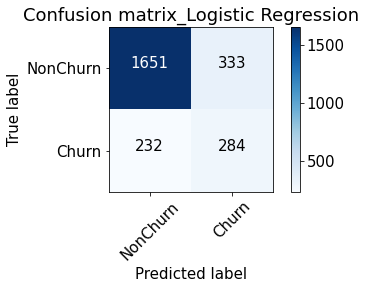

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, preds_lr > thresholds_lr[ix_lr])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix_lr, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix_Logistic Regression')
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
TN_lr = cnf_matrix_lr[0][0]
FP_lr = cnf_matrix_lr[0][1]
FN_lr = cnf_matrix_lr[1][0]
TP_lr = cnf_matrix_lr[1][1]


retain_sum_lr = (FP_lr + TP_lr) * 1
income_lr = TP_lr * 2

income_lr - retain_sum_lr

-49

In [ ]:
grad_boost = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier())
])

grad_boost.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('CreditScore',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='CreditScore')),
                                                                 ('minmax',
                                                                  MinMaxScaler())])),
                                                ('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gende...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', GradientBoostingClassifier())])

In [ ]:
preds_gb = grad_boost.predict_proba(X_test)[:, 1]

precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, preds_gb)

fscore_gb = (2 * precision_gb * recall_gb) / (precision_gb + recall_gb + sys.float_info.epsilon)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print(f'Best Threshold={thresholds_gb[ix_gb]}, F-Score={fscore_gb[ix_gb]:.3f}, Precision={precision_gb[ix_gb]:.3f}, Recall={recall_gb[ix_gb]:.3f}')

Best Threshold=0.29436989210362446, F-Score=0.649, Precision=0.667, Recall=0.632


Confusion matrix, without normalization
[[1821  163]
 [ 191  325]]


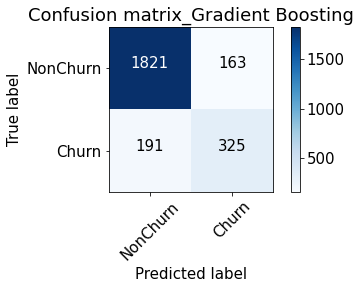

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds_gb > thresholds_gb[ix_gb])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix_gb, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix_Gradient Boosting')
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
TN_gb = cnf_matrix_gb[0][0]
FP_gb = cnf_matrix_gb[0][1]
FN_gb = cnf_matrix_gb[1][0]
TP_gb = cnf_matrix_gb[1][1]


retain_sum_gb = (FP_gb + TP_gb) * 1
income_gb = TP_gb * 2

income_gb - retain_sum_gb

162

In [ ]:
%%time

params_gb = {
    'classifier__n_estimators':  [50, 70, 100],
    'classifier__learning_rate':  [0.001, 0.01, 0.1],
    'classifier__max_depth': [2, 3, 5, 7],
    'classifier__subsample': [0.3, 0.5, 0.7]
}

grid_gb = GridSearchCV(grad_boost,
                    param_grid=params_gb,
                    cv=10,
                    refit=False)

search_gb = grid_gb.fit(X_train, y_train)
search_gb.best_params_

CPU times: user 13min 6s, sys: 1.75 s, total: 13min 7s
Wall time: 13min 12s


{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__subsample': 0.3}

In [ ]:
grad_boost = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.1,
                                              n_estimators=100,
                                              subsample=0.3,
                                              max_depth=3)),
])

grad_boost.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('CreditScore',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='CreditScore')),
                                                                 ('minmax',
                                                                  MinMaxScaler())])),
                                                ('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gende...
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', GradientBoostingClassifier(subsample=0.3))])

In [ ]:
preds_gb = grad_boost.predict_proba(X_test)[:, 1]

precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, preds_gb)

fscore_gb = (2 * precision_gb * recall_gb) / (precision_gb + recall_gb + sys.float_info.epsilon)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print(f'Best Threshold={thresholds_gb[ix_gb]}, F-Score={fscore_gb[ix_gb]:.3f}, Precision={precision_gb[ix_gb]:.3f}, Recall={recall_gb[ix_gb]:.3f}')

Best Threshold=0.3258949302451526, F-Score=0.637, Precision=0.681, Recall=0.599


Confusion matrix, without normalization
[[1839  145]
 [ 208  308]]


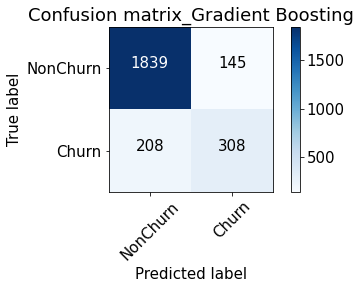

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds_gb > thresholds_gb[ix_gb])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix_gb, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix_Gradient Boosting')
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
TN_gb = cnf_matrix_gb[0][0]
FP_gb = cnf_matrix_gb[0][1]
FN_gb = cnf_matrix_gb[1][0]
TP_gb = cnf_matrix_gb[1][1]


retain_sum_gb = (FP_gb + TP_gb) * 1
income_gb = TP_gb * 2

income_gb - retain_sum_gb

163